In [1]:
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.12.7


In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore


In [3]:
df = pd.read_csv('bcdata.sgs.4390.csv',sep=";", encoding='utf-8')

In [4]:
df.shape

(469, 2)

In [5]:
df.head()

,data,valor
0,01/08/1986,"2,57"
1,01/09/1986,"2,94"
2,01/10/1986,"1,96"
3,01/11/1986,"2,37"
4,01/12/1986,"5,47"


In [6]:
df.tail()

,data,valor
464,01/04/2025,"1,06"
465,01/05/2025,"1,14"
466,01/06/2025,"1,10"
467,01/07/2025,"1,28"
468,01/08/2025,"1,11"


In [7]:
df.dtypes

data     object
valor    object
dtype: object

In [8]:
df['valor'].describe()

count      469
unique     267
top       0,84
freq         8
Name: valor, dtype: object

In [9]:
df['valor'].min(),df['valor'].max(),

('0,13', '9,67')

In [10]:
df.loc[df['valor'].idxmax()]
df.loc[df['valor'].idxmin()]

data     01/02/2021
valor          0,13
Name: 414, dtype: object

In [11]:
df['data'] = pd.to_datetime(df['data'], dayfirst=True)

In [12]:
df.sort_values('data', inplace=True)

In [13]:
df['valor'] = df['valor'].astype(str).str.replace(',', '.').astype(float)
df['variacao (%)'] = df['valor'].pct_change() * 100

In [14]:
df['crescimento acumulado'] = df['valor'].cumsum()

In [15]:
taxa_media = ((df['valor'].iloc[-1] / df['valor'].iloc[0]) ** (1 / len(df)) - 1) * 100

In [16]:
df[['valor','variacao (%)','crescimento acumulado']].describe()

,valor,variacao (%),crescimento acumulado
count,469.000000,468.000000,469.000000
mean,5.953284,1.803922,2291.470043
std,11.481578,19.249589,736.005869
min,0.130000,-88.492927,2.570000
25%,0.840000,-6.829015,2413.070000
50%,1.200000,0.000000,2603.630000
75%,2.570000,9.090909,2706.030000
max,82.040000,138.757655,2792.090000


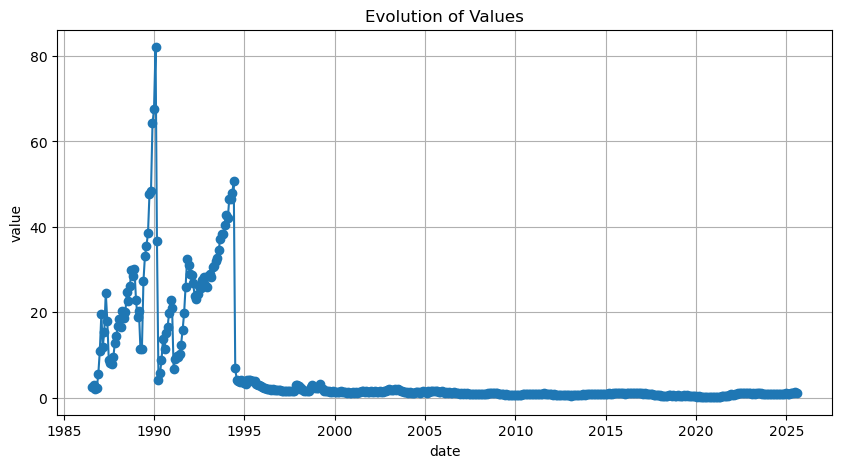

In [17]:
plt.figure(figsize=(10,5))
plt.plot(df['data'], df['valor'], marker='o')
plt.title('Evolution of Values')
plt.xlabel('date')
plt.ylabel('value')
plt.grid()
plt.show()

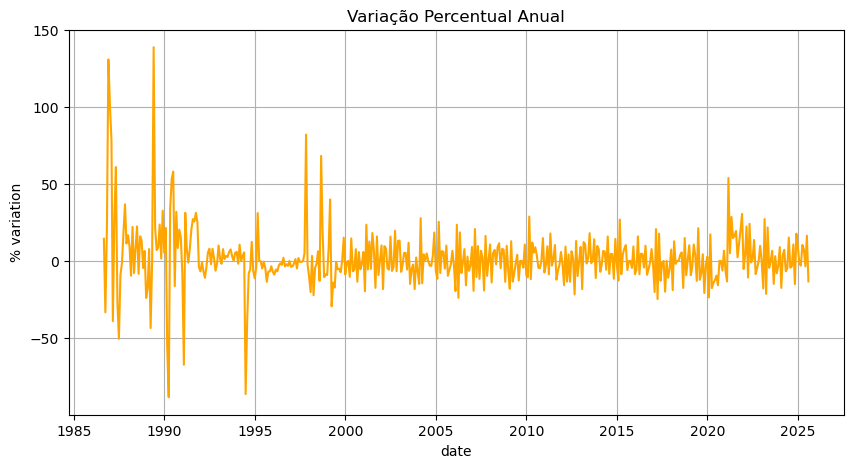

In [18]:
plt.figure(figsize=(10,5))
plt.plot(df['data'], df['variacao (%)'], color='orange')
plt.title('Variação Percentual Anual')
plt.xlabel('date')
plt.ylabel('% variation')
plt.grid()
plt.show()

# Linear Trend (Linear Regression)

In [19]:
X = np.arange(len(df)).reshape(-1,1)
y = df['valor'].values

In [20]:
modelo_lr = LinearRegression()
modelo_lr.fit(X,y)

LinearRegression()

In [21]:
df['tendencia linear'] = modelo_lr.predict(X)

# Forecast of future values

In [22]:
modelo_arima = ARIMA(df['valor'], order=(1,1,1))
resultado_arima = modelo_arima.fit()

In [23]:
previsao = resultado_arima.forecast(steps=6)
datas_futuras = pd.date_range(df['data'].iloc[-1] + pd.offsets.MonthBegin(1), periods=6, freq="MS")
forecast_df = pd.DataFrame({'data': datas_futuras, 'previsao arima': previsao})

# Anomaly detection

In [24]:
df['zscore'] = zscore(df['valor'])
df['anomalia'] = df['zscore'].abs() >2

# Seasonality analysis

In [25]:
decomposicao = seasonal_decompose(df.set_index('data')['valor'], model='additive', period=12)

# Views

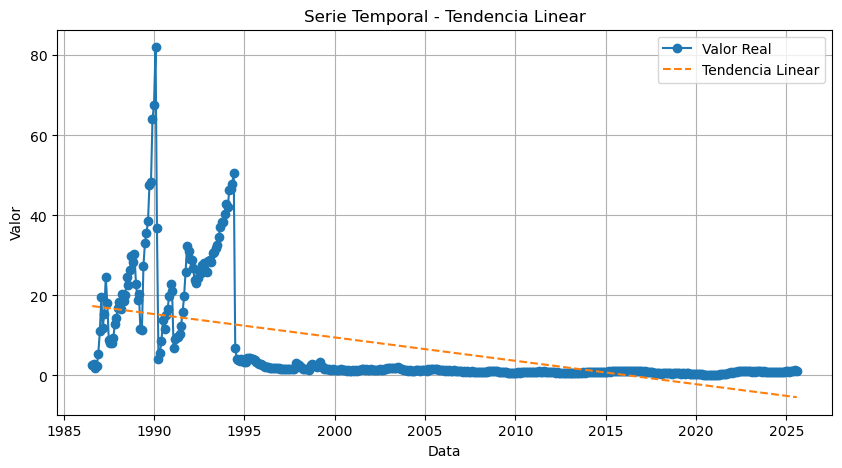

In [26]:
# Serie Original + tendencia Linear
plt.figure(figsize=(10,5))
plt.plot(df['data'], df['valor'],marker='o', label='Valor Real')
plt.plot(df['data'], df['tendencia linear'],linestyle='--', label='Tendencia Linear')
plt.title('Serie Temporal - Tendencia Linear')
plt.xlabel("Data")
plt.ylabel("Valor")
plt.legend()
plt.grid()
plt.show()

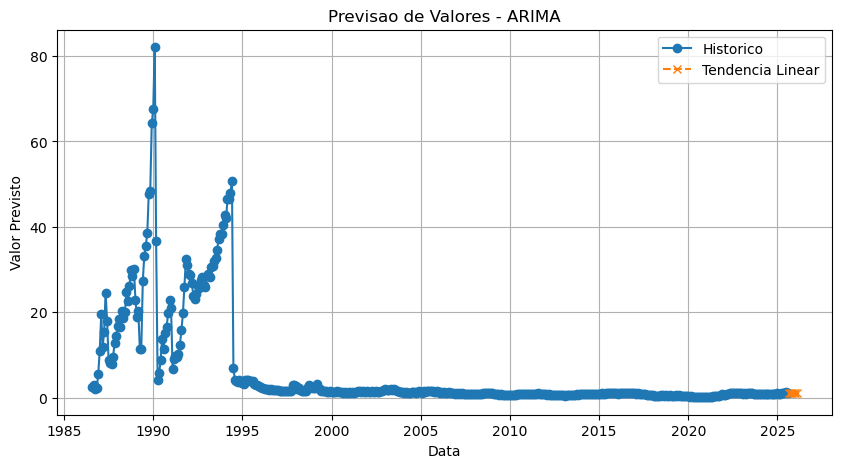

In [27]:
# Previsao ARIMA
plt.figure(figsize=(10,5))
plt.plot(df['data'], df['valor'],marker='o', label='Historico')
plt.plot(forecast_df['data'], forecast_df['previsao arima'],marker='x',linestyle='--', label='Tendencia Linear')
plt.title('Previsao de Valores - ARIMA')
plt.xlabel("Data")
plt.ylabel("Valor Previsto")
plt.legend()
plt.grid()
plt.show()

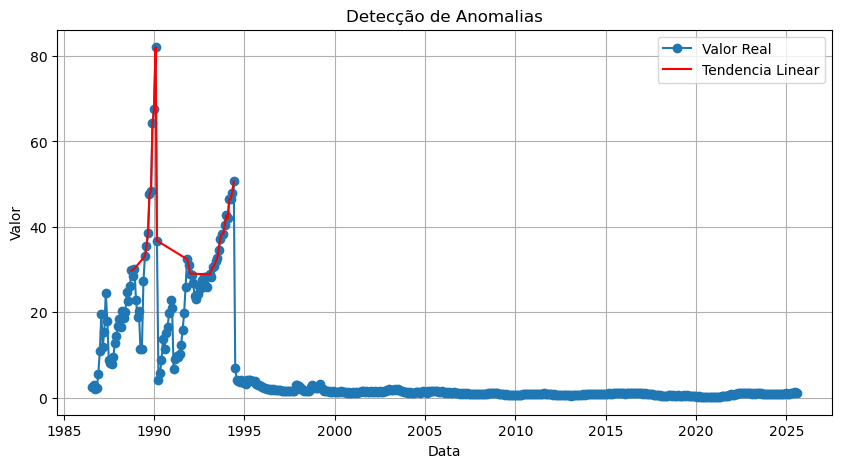

In [28]:
# Anomalias detectadas
plt.figure(figsize=(10,5))
plt.plot(df['data'], df['valor'],marker='o', label='Valor Real')
plt.plot(df[df['anomalia']]['data'],df[df['anomalia']]['valor'],color='red', label='Tendencia Linear')
plt.title('Detecção de Anomalias')
plt.xlabel("Data")
plt.ylabel("Valor")
plt.legend()
plt.grid()
plt.show()

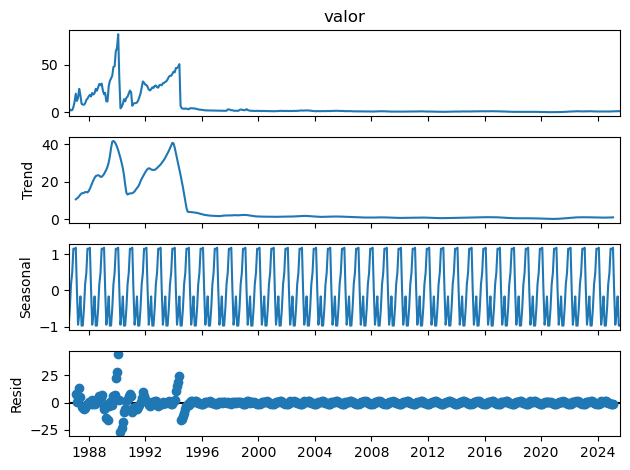

In [29]:
decomposicao.plot()
plt.show()

In [30]:
print("\n===== DataFrame com Cálculos =====")
print(df)
print("\n===== Previsão ARIMA =====")
print(forecast_df)


===== DataFrame com Cálculos =====
          data  valor  variacao (%)  crescimento acumulado  tendencia linear  \
0   1986-08-01   2.57           NaN                   2.57         17.346242   
1   1986-09-01   2.94     14.396887                   5.51         17.297554   
2   1986-10-01   1.96    -33.333333                   7.47         17.248866   
3   1986-11-01   2.37     20.918367                   9.84         17.200178   
4   1986-12-01   5.47    130.801688                  15.31         17.151490   
..         ...    ...           ...                    ...               ...   
464 2025-04-01   1.06     10.416667                2787.46         -5.244923   
465 2025-05-01   1.14      7.547170                2788.60         -5.293611   
466 2025-06-01   1.10     -3.508772                2789.70         -5.342299   
467 2025-07-01   1.28     16.363636                2790.98         -5.390987   
468 2025-08-01   1.11    -13.281250                2792.09         -5.439675   

   